# Example 003 - use band replacement to include optical sectionining as part of 2D-SIM reconstruction
  
In real samples, there is often background due to fluorescence from above / below the focal plane. This lowers modulation contrast to noise ratio (MCNR) and limits the reconstruction quality for 2D-SIM. Here, we introduce a variant on the methods demonstrated by XXX and YYY to achieve optical sectioning due 2D-SIM reconstruction.

We utilize a z-stack of 2D-SIM acquisitions through a tetrahymena sample, immunofluorescence labeled for basal bodies, as our dataset. 

### Import libraries

In [59]:
import os
import pickle
from pathlib import Path
import mcsim.analysis.sim_reconstruction as sim
import localize_psf.fit_psf as psf
import localize_psf.affine as affine
import localize_psf.rois as rois
import napari
import tifffile
import numpy as np
from numpy import fft
from mcsim.analysis import analysis_tools
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

### Load experimental data containing all z stage positions and patterns.

In [10]:
ncolors = 1
nangles = 3
nphases = 3
nz = 35
nx = 2048
ny = 2048
imgs = tifffile.imread(Path("data", "example_003","raw_data","tetrahymena_basal_bodies.tif")).reshape([ncolors, nangles, nphases, nz, ny, nx])

### Define experimental metadata

In [11]:
na = 1.3
pixel_size = 0.065
dz = 0.250
excitation_wavelengths = 0.465
emission_wavelengths = 0.509

### View raw DMD-SIM data

In [53]:
viewer = napari.view_image(imgs,name='Raw DMD-SIM',scale=(1,1,1,dz,pixel_size,pixel_size))

### Define region of interest containing data

In [42]:
# [cy, cx]
roi = rois.get_centered_roi([1230, 996], [731, 631])
nx_roi = roi[3] - roi[2]
ny_roi = roi[1] - roi[0]

### Load experimental optical transfer function

In [44]:
otf_data_path = Path("data", "example_003", "calibration", "2020_05_19_otf_fit_blue.pkl")

with open(otf_data_path, 'rb') as f:
    otf_data = pickle.load(f)
otf_p = otf_data['fit_params']

otf_fn = lambda f, fmax: 1 / (1 + (f / fmax * otf_p[0]) ** 2) * psf.circ_aperture_otf(f, 0, na, 2 * na / fmax)

### Load pre-calculated affine transforms for qi2lab DMD-SIM.

In [45]:
affine_fnames = [Path("data", "example_003", "calibration", "2021-04-13_12;49;32_affine_xform_blue_z=0.pkl")]

affine_xforms = []
for p in affine_fnames:
    with open(p, 'rb') as f:
        affine_xforms.append(pickle.load(f)['affine_xform'])

### Load qi2lab DMD-SIM patterns. Estimate frequency and phase using extracted affine transforms.

In [51]:
dmd_pattern_data_fpath = [Path("data", "example_003", "calibration", "period=6.0_nangles=3", "wavelength=473nm", "sim_patterns_period=6.01_nangles=3.pkl")]

frqs_dmd = np.zeros((2, 3, 2))
phases_dmd = np.zeros((ncolors, nangles, nphases))

for kk in range(ncolors):
    ppath = dmd_pattern_data_fpath[kk]
    xform = affine_xforms[kk]

    with open(ppath, 'rb') as f:
        pattern_data = pickle.load(f)

    # DMD intensity frequency and phase (twice electric field frq/phase)
    frqs_dmd[kk] = 2 * pattern_data['frqs']
    phases_dmd[kk] = 2 * pattern_data['phases']
    dmd_nx = pattern_data['nx']
    dmd_ny = pattern_data['ny']

for kk in range(ncolors):
    # otf matrix
    fmax = 1 / (0.5 * emission_wavelengths / na)
    fx = fft.fftshift(fft.fftfreq(nx_roi, pixel_size))
    fy = fft.fftshift(fft.fftfreq(ny_roi, pixel_size))
    ff = np.sqrt(fx[None, :] ** 2 + fy[:, None] ** 2)
    otf = otf_fn(ff, fmax)
    otf[ff >= fmax] = 0

    # guess frequencies/phases
    frqs_guess = np.zeros((nangles, 2))
    phases_guess = np.zeros((nangles, nphases))
    for ii in range(nangles):
        for jj in range(nphases):
            # estimate frequencies based on affine_xform
            frqs_guess[ii, 0], frqs_guess[ii, 1], phases_guess[ii, jj] = \
                affine.xform_sinusoid_params_roi(frqs_dmd[kk, ii, 0], frqs_dmd[kk, ii, 1],
                                                 phases_dmd[kk, ii, jj], [dmd_ny, dmd_nx], roi, xform)

    # convert from 1/mirrors to 1/um
    frqs_guess = frqs_guess / pixel_size

### Perform SIM reconstruction

####################################################################################
2022/04/29 19:17:16
####################################################################################
Normalizing histograms took 0.61s
FT images took 0.73s
Computing widefield image took 0.53s
Computing SIM-OS image took 0.11s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   12.2s finished


estimating 3 frequencies took 13.07s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.18s
estimated modulation-contrast-to-noise ratio in 0.32s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.7s finished


estimated 9 phases in 4.94s using mode 'wicker-iterative'
separated bands in 0.09s
estimated noise in 0.15s
shifted bands in 3.40s
shifted otfs in 0.48s
estimated global phases and mod depths in 0.40s
computed band weights in 1.21s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 1.27s
Deconvolved widefield in 0.79s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.960
phase relative intensities = 1.000, 0.960, 0.936, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 0.789, 1.399, 0.588
modulation depth = 0.030
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.26977, -1.97405), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.5s finished


estimating 3 frequencies took 6.17s using mode 'band-correlation'
Angle 0, minimum SIM peak-to-noise ratio = 0.09 is less than the minimum value, 0.20, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.30s
estimated modulation-contrast-to-noise ratio in 0.19s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished


estimated 9 phases in 3.90s using mode 'wicker-iterative'
separated bands in 0.08s
estimated noise in 0.17s
shifted bands in 2.41s
shifted otfs in 0.43s
estimated global phases and mod depths in 0.51s
computed band weights in 1.01s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 1.10s
Deconvolved widefield in 1.33s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.938
phase relative intensities = 1.000, 0.978, 0.960, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 0.655, 0.964, 1.049
modulation depth = 0.146
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.17177, -1.92692), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished


estimating 3 frequencies took 6.79s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.17s
estimated modulation-contrast-to-noise ratio in 0.24s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished


estimated 9 phases in 5.31s using mode 'wicker-iterative'
separated bands in 0.12s
estimated noise in 0.14s
shifted bands in 3.07s
shifted otfs in 0.45s
estimated global phases and mod depths in 0.50s
computed band weights in 1.09s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 1.72s
Deconvolved widefield in 0.73s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.936
phase relative intensities = 1.000, 0.977, 0.963, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 2.809, 2.194, 1.739
modulation depth = 0.080
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.15671, -1.90374), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished


estimating 3 frequencies took 5.83s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.20s
estimated modulation-contrast-to-noise ratio in 0.25s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished


estimated 9 phases in 4.81s using mode 'wicker-iterative'
separated bands in 0.09s
estimated noise in 0.16s
shifted bands in 3.34s
shifted otfs in 0.46s
estimated global phases and mod depths in 0.47s
computed band weights in 1.07s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 1.20s
Deconvolved widefield in 0.79s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.936
phase relative intensities = 1.000, 0.975, 0.967, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 4.248, 4.418, 3.697
modulation depth = 0.291
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.15106, -1.92933), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished


estimating 3 frequencies took 5.92s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.16s
estimated modulation-contrast-to-noise ratio in 0.28s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished


estimated 9 phases in 4.67s using mode 'wicker-iterative'
separated bands in 0.09s
estimated noise in 0.18s
shifted bands in 2.93s
shifted otfs in 0.40s
estimated global phases and mod depths in 0.52s
computed band weights in 0.96s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 1.29s
Deconvolved widefield in 0.78s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.939
phase relative intensities = 1.000, 0.976, 0.967, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 27.605, 27.243, 26.468
modulation depth = 0.561
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.15829, -1.93387

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.1s finished


estimating 3 frequencies took 5.82s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.21s
estimated modulation-contrast-to-noise ratio in 0.23s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished


estimated 9 phases in 4.73s using mode 'wicker-iterative'
separated bands in 0.08s
estimated noise in 0.17s
shifted bands in 3.08s
shifted otfs in 0.49s
estimated global phases and mod depths in 0.52s
computed band weights in 1.06s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 1.41s
Deconvolved widefield in 0.60s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.940
phase relative intensities = 1.000, 0.977, 0.970, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 55.273, 51.057, 55.099
modulation depth = 0.786
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.15629, -1.93060

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished


estimating 3 frequencies took 5.99s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.17s
estimated modulation-contrast-to-noise ratio in 0.27s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished


estimated 9 phases in 4.81s using mode 'wicker-iterative'
separated bands in 0.14s
estimated noise in 0.16s
shifted bands in 2.95s
shifted otfs in 0.38s
estimated global phases and mod depths in 0.50s
computed band weights in 1.19s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 1.44s
Deconvolved widefield in 0.62s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.941
phase relative intensities = 1.000, 0.975, 0.966, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 57.729, 51.278, 60.005
modulation depth = 0.638
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.15670, -1.93083

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished


estimating 3 frequencies took 6.06s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.23s
estimated modulation-contrast-to-noise ratio in 0.25s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished


estimated 9 phases in 4.80s using mode 'wicker-iterative'
separated bands in 0.08s
estimated noise in 0.25s
shifted bands in 3.26s
shifted otfs in 0.39s
estimated global phases and mod depths in 0.49s
computed band weights in 1.34s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 1.42s
Deconvolved widefield in 0.66s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.939
phase relative intensities = 1.000, 0.973, 0.962, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 39.976, 32.929, 39.402
modulation depth = 0.491
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.15574, -1.93181

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.5s finished


estimating 3 frequencies took 7.23s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.21s
estimated modulation-contrast-to-noise ratio in 0.28s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.6s finished


estimated 9 phases in 6.81s using mode 'wicker-iterative'
separated bands in 0.09s
estimated noise in 0.16s
shifted bands in 3.81s
shifted otfs in 0.43s
estimated global phases and mod depths in 0.60s
computed band weights in 1.33s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 1.76s
Deconvolved widefield in 0.68s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.942
phase relative intensities = 1.000, 0.975, 0.961, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 18.955, 18.252, 18.191
modulation depth = 0.447
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.16168, -1.93228

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished


estimating 3 frequencies took 6.77s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.22s
estimated modulation-contrast-to-noise ratio in 0.30s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s finished


estimated 9 phases in 5.57s using mode 'wicker-iterative'
separated bands in 0.13s
estimated noise in 0.18s
shifted bands in 3.34s
shifted otfs in 0.43s
estimated global phases and mod depths in 0.51s
computed band weights in 1.27s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 1.53s
Deconvolved widefield in 0.81s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.940
phase relative intensities = 1.000, 0.978, 0.958, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 12.158, 12.040, 12.334
modulation depth = 0.442
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.16878, -1.93806

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished


estimating 3 frequencies took 7.04s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.23s
estimated modulation-contrast-to-noise ratio in 0.32s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.6s finished


estimated 9 phases in 5.79s using mode 'wicker-iterative'
separated bands in 0.10s
estimated noise in 0.20s
shifted bands in 3.52s
shifted otfs in 0.47s
estimated global phases and mod depths in 0.51s
computed band weights in 1.43s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 1.69s
Deconvolved widefield in 0.88s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.938
phase relative intensities = 1.000, 0.983, 0.962, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 8.899, 8.889, 7.915
modulation depth = 0.470
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.16741, -1.94057), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.4s finished


estimating 3 frequencies took 7.07s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.25s
estimated modulation-contrast-to-noise ratio in 0.37s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.8s finished


estimated 9 phases in 7.20s using mode 'wicker-iterative'
separated bands in 0.11s
estimated noise in 0.20s
shifted bands in 3.94s
shifted otfs in 0.50s
estimated global phases and mod depths in 0.62s
computed band weights in 1.30s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 2.17s
Deconvolved widefield in 1.23s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.942
phase relative intensities = 1.000, 0.984, 0.963, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 8.373, 8.873, 7.442
modulation depth = 0.484
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.15945, -1.94018), 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.1s finished


estimating 3 frequencies took 7.82s using mode 'band-correlation'
estimated peak-to-noise ratio in 0.23s
estimated modulation-contrast-to-noise ratio in 0.39s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.0s finished


estimated 9 phases in 10.48s using mode 'wicker-iterative'
separated bands in 0.11s
estimated noise in 0.23s
shifted bands in 4.47s
shifted otfs in 0.54s
estimated global phases and mod depths in 0.76s
computed band weights in 1.71s
combining bands using mode 'fairSIM' and Wiener parameter 0.400 took 2.26s
Deconvolved widefield in 0.88s
SIM reconstruction for 3 angles and 3 phases
images are size 731x631 with pixel size 0.065um
emission wavelength=509nm and NA=1.30
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.40
################ Angle 0 ################
relative intensity to max angle = 0.940
phase relative intensities = 1.000, 0.984, 0.966, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 8.475, 9.693, 9.248
modulation depth = 0.524
Frequency guess= (-3.17177, -1.92692), period=269.453nm, angle=-148.720deg
Frequency fit  = (-3.16652, -1.93950),

KeyboardInterrupt: 

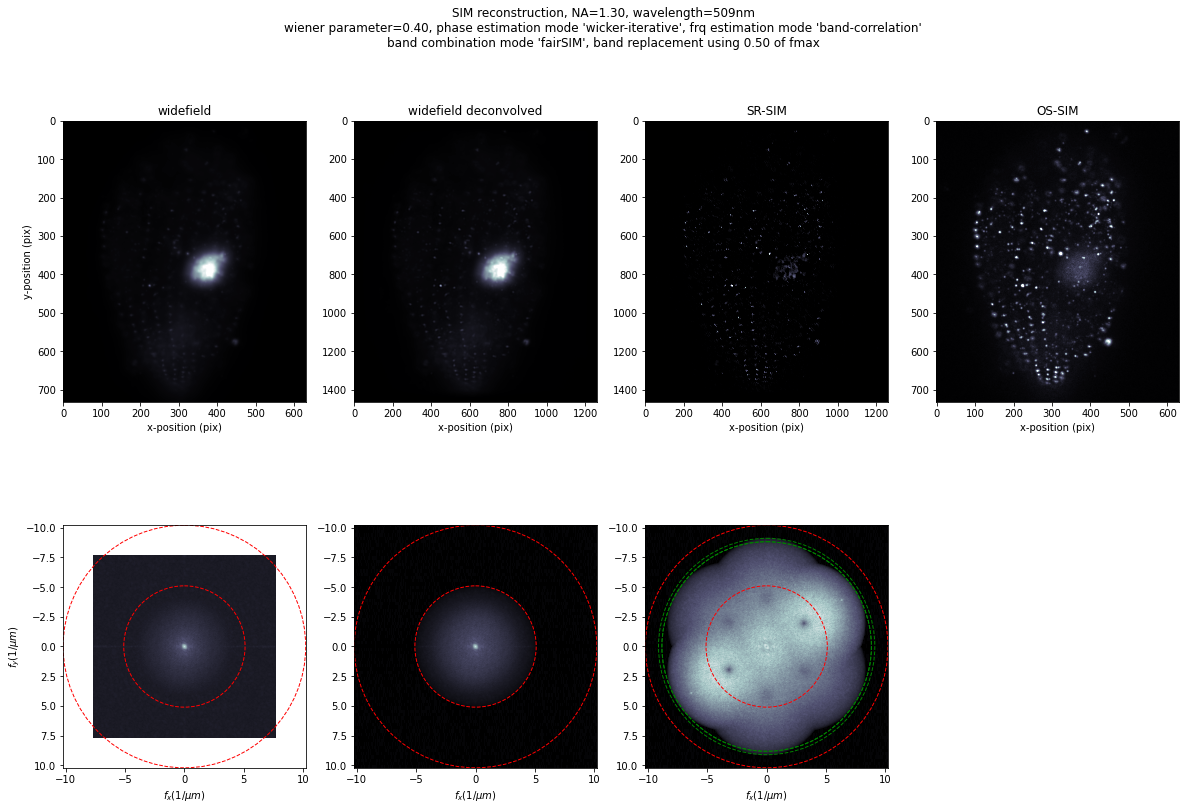

In [70]:
%matplotlib inline
save_path = Path("data","example_004","reconstruction")
for ch_idx in range(ncolors):
    for z_idx in range(nz):
        imgset = sim.SimImageSet({"pixel_size": pixel_size, "na": na, "wavelength": emission_wavelengths},
                                imgs[0, :, :, z_idx, roi[0]:roi[1], roi[2]:roi[3]],
                                frq_estimation_mode="band-correlation",
                                frq_guess=frqs_guess,
                                phases_guess=phases_guess,
                                phase_estimation_mode="wicker-iterative",
                                combine_bands_mode="fairSIM",
                                fmax_exclude_band0=0.5,
                                normalize_histograms=True,
                                otf=otf,
                                wiener_parameter=0.1,
                                background=100, 
                                gain=1, 
                                min_p2nr=0.2, 
                                max_phase_err=15,
                                save_dir=Path("data","example_003","reconstruction"),
                                save_suffix="_z"+str(z_idx).zfill(3)+"_ch"+str(ch_idx).zfill(3),
                                interactive_plotting=False, 
                                figsize=(20, 13))

        imgset.reconstruct()
        imgset.plot_figs()
        imgset.save_imgs()
        imgset.log_file.close()

        if ch_idx == 0 and z_idx == 0:
            wf_images = np.zeros((ncolors,nz,imgset.widefield.shape[0],imgset.widefield.shape[1]),dtype=np.float32)
            SR_images = np.zeros((ncolors,nz,imgset.sim_sr.shape[0],imgset.sim_sr.shape[1]),dtype=np.float32)
        wf_images[ch_idx,z_idx,:]=imgset.widefield
        SR_images[ch_idx,z_idx,:]=imgset.sim_sr

        del imgset

### Display results

In [69]:
colormaps = ['bop blue', 'bop orange']

viewer = napari.view_image(wf_images[ch_idx,:],name='Widefield CH '+str(ch_idx).zfill(2),scale=(dz,pixel_size,pixel_size),colormap = colormaps[0],blending='additive',contrast_limits=[0,2**16-1])
viewer.add_image(SR_images[ch_idx,:],name='SR CH '+str(ch_idx).zfill(2),scale=(dz,pixel_size/2,pixel_size/2),colormap = colormaps[1],blending='additive',contrast_limits=[1e3,2**16-1])

viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

Exception in callback BaseAsyncIOLoop._handle_events(10360, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(10360, 1)>
Traceback (most recent call last):
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\zmq\eventloop\zmqstream.py", line 452, in _handle_events
    self._handle_recv()
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\zmq\eventloop\zmqstream.py", line 481, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\zmq\eventloop\zmqstream.py", line 431, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\dpshe\miniconda3\envs\mcsimi2k\lib\site-packages\jupyter_client\threade

### Calculate FFT of raw data to find frequency guesses

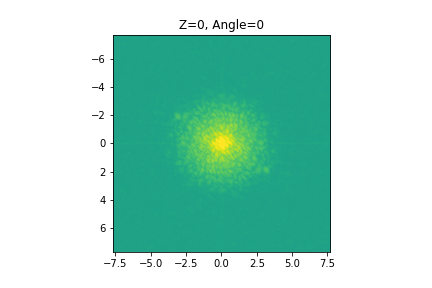

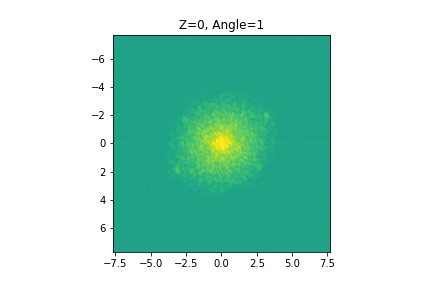

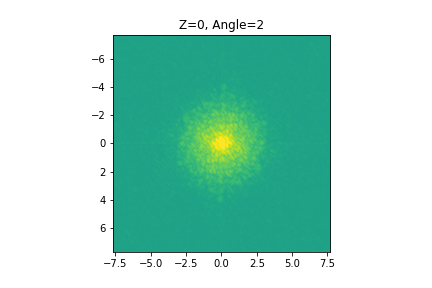

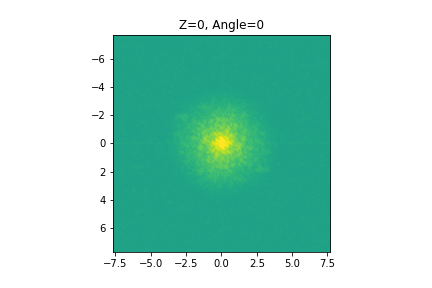

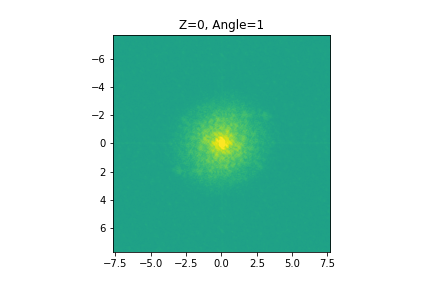

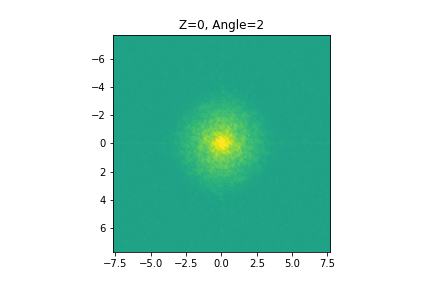

In [62]:
%matplotlib widget
for z_idx in range(8,10):

    image_set = imgs[0, :, :, z_idx, :, :]

    dx = pixel_size
    fxs = analysis_tools.get_fft_frqs(nx, dx)
    df = fxs[1] - fxs[0]
    fys = analysis_tools.get_fft_frqs(ny, dx)
    ff = np.sqrt(np.expand_dims(fxs, axis=0)**2 + np.expand_dims(fys, axis=1)**2)
    for ii in range(image_set.shape[0]):
        ft = fft.fftshift(fft.fft2(fft.ifftshift(np.squeeze(image_set[ii, 0, :]))))

        figh = plt.figure()
        plt.title('Z='+str(ch_idx)+", Angle="+str(ii))
        plt.imshow(np.abs(ft), norm=PowerNorm(gamma=0.1,vmin=65,vmax=1.5e7),
                    extent=[fxs[0] - 0.5 * df, fxs[-1] + 0.5 * df, fys[-1] + 0.5 * df, fys[0] - 0.5 * df])
        plt.show()